# Rain and Drizzle Comparison
### Jayke Samson Nguyen
2022-04-20

# Check Images

This is a comparison analyzing the differences between Rain and Drizzle. In total there are seven check images to check the performance of Rain vs. Drizzle.

The Gaussian kernel images were transformed using a pixel fraction of 0.5, number of divisions is 32.

The Lanczos 3 kernel images were transformed using a pixel fraction of 1, number of divisions is 1.

There are small differences between the two as we will highlight in the following analysis.

The first four are single pixels equal of value 1 at various shifts.

* no shift
* half pixel positive shift
* quarter pixel positive shift
* random positive shift (1/1.232, 1/3.1413)

The next three are fake PSFs which are linear combinations of Lorentzian and Airy distributions that are similar to Keck PSFs.

* half pixel positive shift, with noise
* quarter pixel positive shift, with noise
* no shift

# Notes

The Lanczos 3 resampling needs to have a number of divisions equal to 1. The behavior of this function isn't the same as the Gaussian case. Pixel flux is not idealized as being the area under the curve of the Lanczos 3 function, it is *not* a probability distribution. See [Wikipedia page on Lanczos resampling](https://en.wikipedia.org/wiki/Lanczos_resampling). Lanczos 3 resampling is applying the function to the pixel (under y-scaling and translation) and sampling at the fine grid points near the pixel. Since the area of the curve is not equal to 1, some care needs to be taken to renormalize the flux.

Gaussian resampling needs multiple divisions to be accurate since total pixel flux is the area under the curve and it is more similar to a probability distribution.

In [1]:
import sys
sys.path.insert(1, '..')

import os

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import special

from tqdm import tqdm

from rain import *

In [2]:
def read_check_image_set(num=None, filenames=None):
    data_folder = '../check_images/'

    djoin = lambda a : os.path.join(data_folder,a)
    
    if filenames is None and num is not None:
        names = [
                 'check_image_{}.fits',
                 'rain_gauss_check_image_{}.fits',
                 'rain_lanc3_check_image_{}.fits',
                 'drz_gauss_check_image_{}.fits',
                 'drz_lanc3_check_image_{}.fits',
                 'check_image_{}_dist_x.fits',
                 'check_image_{}_dist_y.fits'
                ]
        
        filenames = [djoin(n.format(num))for n in names]


    data = [fits.getdata(fn) for fn in filenames]
    images = data[0:3]

    data = {'orig': data[0],
            'rain_gauss': data[1],
            'rain_lanc3': data[2],
            'driz_gauss': data[3],
            'driz_lanc3': data[4],
            'dist_x': data[5],
            'dist_y': data[6]}
    
    return data

In [3]:
def plot_set(data, vms=None):

    fig, axs = plt.subplots(5,3, figsize=(6,12))
        
    vmin,vmax = vms[0]
    
    axs[0,0].imshow(data['orig'], origin='lower', vmin=vmin, vmax=vmax)
    axs[0,1].axis('off')
    axs[0,2].axis('off')

    axs[1,0].imshow(data['rain_gauss'], origin='lower', vmin=vmin, vmax=vmax)
    axs[1,1].imshow(data['driz_gauss'], origin='lower', vmin=vmin, vmax=vmax)
    axs[1,2].axis('off')

    
    axs[2,0].imshow(data['rain_lanc3'], origin='lower', vmin=vmin, vmax=vmax)
    axs[2,1].imshow(data['driz_lanc3'], origin='lower', vmin=vmin, vmax=vmax)
    axs[2,2].axis('off')

    vmin, vmax = vms[1]
    
    axs[3,0].imshow(data['orig']-data['rain_gauss'], origin='lower', vmin=vmin, vmax=vmax)
    axs[3,1].imshow(data['orig']-data['driz_gauss'], origin='lower', vmin=vmin, vmax=vmax)
    axs[3,2].imshow(data['driz_gauss']-data['rain_gauss'], origin='lower', vmin=vmin, vmax=vmax)
   
    axs[4,0].imshow(data['orig']-data['rain_lanc3'], origin='lower', vmin=vmin, vmax=vmax)
    axs[4,1].imshow(data['orig']-data['driz_lanc3'], origin='lower', vmin=vmin, vmax=vmax)
    axs[4,2].imshow(data['driz_lanc3']-data['rain_lanc3'], origin='lower', vmin=vmin, vmax=vmax)
   

    axs[0,0].set_title('Original')

    axs[1,0].set_title('Rain Gauss')
    axs[1,1].set_title('Drizzle Gauss')
    
    axs[2,0].set_title('Rain Lanc3')
    axs[2,1].set_title('Drizzle Lanc3')
    
    axs[3,0].set_title('O-R Gauss') 
    axs[3,1].set_title('O-D Gauss')
    axs[3,2].set_title('D-R Gauss')
    axs[4,0].set_title('O-R Lanc3') 
    axs[4,1].set_title('O-D Lanc3')
    axs[4,2].set_title('D-R Lanc3')
    
    for ax in np.ravel(axs):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
    return fig, axs

In [4]:
def plot_cross_section(data, distortion=None, index=None):
    
    if index is None:
        index = int(data['orig'].shape[0]/2)
    
    fig, axs = plt.subplots(1,4, figsize=(16,4))

    axs[0].plot(data['rain_lanc3'][index], color='black', marker='o')
    axs[0].plot(data['driz_lanc3'][index], color='red', linestyle='--', alpha=0.8, marker='o')

    if distortion is not None:
        xs = np.linspace(0,16,1000)
        y = index
        amplitude = 1 / lanczos3_norm()
        x0 = 8+distortion[0]
        y0 = 8+distortion[1]
        radius = 3

        val = []
        for x in xs:
            val.append(lanczos3(x, y, amplitude, x0, y0, radius))
        val = np.array(val)

        axs[0].plot(xs, val, linestyle='--')

    axs[0].set_xlim(0,data['orig'].shape[1]-1)
    
    axs[1].plot(data['driz_lanc3'][index]-data['rain_lanc3'][index], marker='o')
    
    axs[0].set_title('Overlay')
    axs[1].set_title('Subtraction')
    
    axs[2].plot(data['rain_gauss'][index], color='black', marker='o')
    axs[2].plot(data['driz_gauss'][index], color='red', linestyle='--', alpha=0.8, marker='o')
    
    if distortion is not None:
        xs = np.linspace(0,16,1000)
        y = index
        pixel_frac = 0.5
        sigma = pixel_frac/(2*np.sqrt(2*np.log(2)))

        amplitude = 1 / gaussian_2d_norm(sigma,sigma)
        print(amplitude)
        x0 = 8+distortion[0]
        y0 = 8+distortion[1]

        val = []
        for x in xs:
            val.append(gaussian_2d(x, y, amplitude, x0, y0, sigma,sigma))
        val = np.array(val)

        axs[2].plot(xs, val, linestyle='--')
    
    axs[3].plot(data['driz_gauss'][index]-data['rain_lanc3'][index], marker='o')
    
    return fig, axs

# Image Plots

The images are plotted along with the subtraction maps. We plot the original image, the Rain images, the drizzle images, with both Gaussian and Lanczos 3 kernels, and combinations of the subtraction of the images.

* "O-R" Means the original image minus the rained image
* "O-D" Means the original image minus the drizzled image
* "D-R" Means the drizzled image minus the rained image

There are small differences between the two images, with the rained images being systematically lower in flux by ~99%.

In [5]:
from matplotlib import font_manager

font_path =  '/Users/jsn/Library/Fonts/IBMPlexMono-Regular.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()

Check Image 0


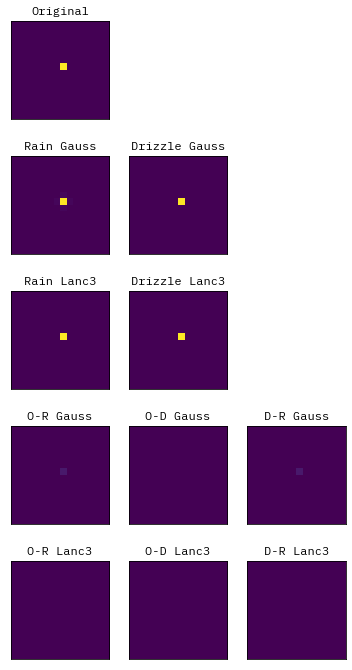

----------------------------------------------------------------
Check Image 1


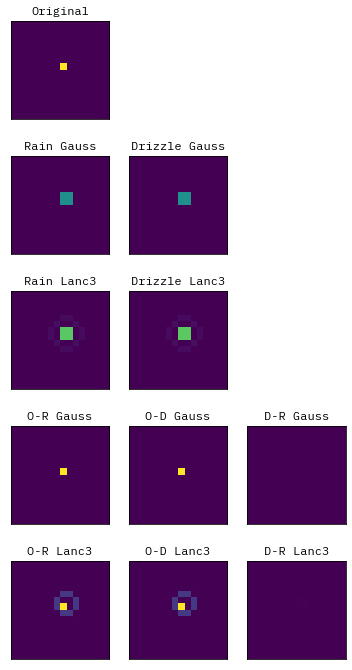

----------------------------------------------------------------
Check Image 2


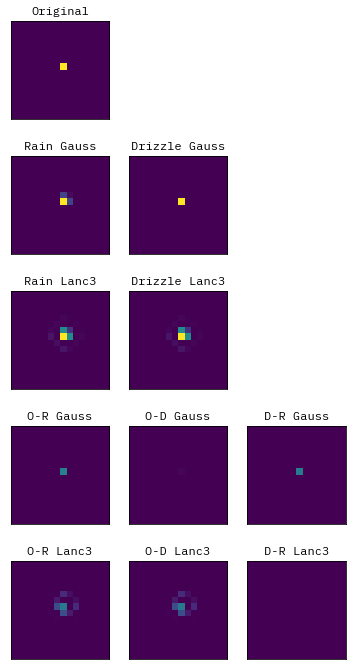

----------------------------------------------------------------
Check Image 3


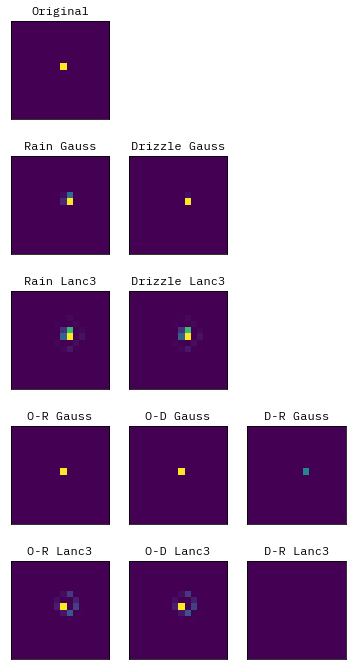

----------------------------------------------------------------
Check Image 4


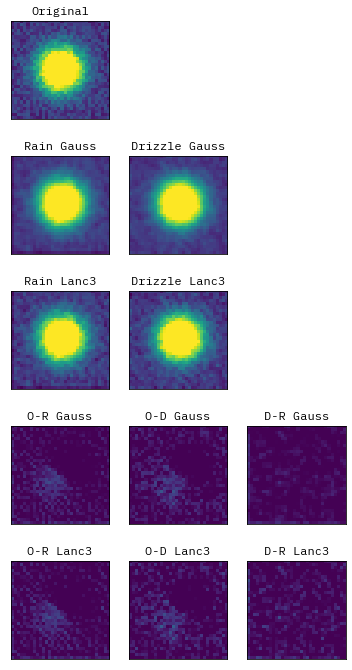

----------------------------------------------------------------
Check Image 5


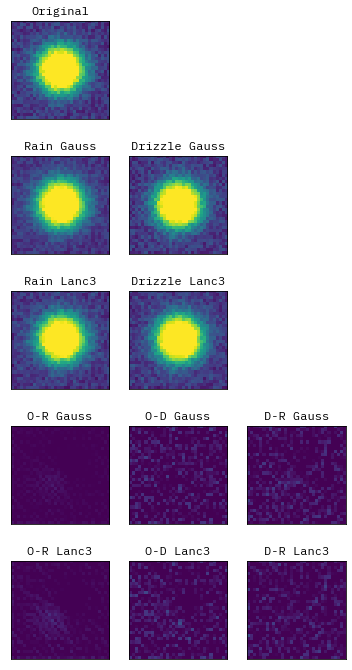

----------------------------------------------------------------
Check Image 6


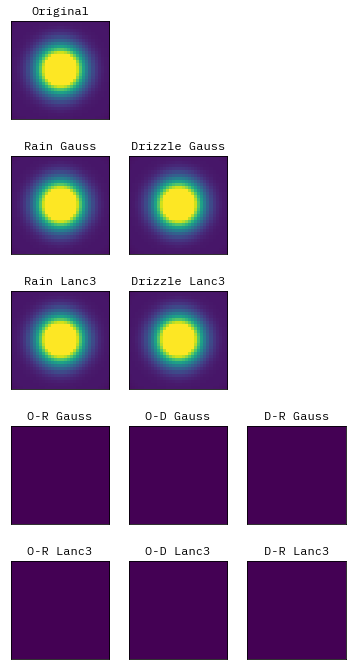

----------------------------------------------------------------


In [6]:
n_images = 7
vms = ((0,0.5),(0,0.5))
for i in range(n_images):
    data = read_check_image_set(num=i)
    print('Check Image {}'.format(i))
    fig, axs = plot_set(data, vms=vms)
    plt.show()
    print('-'*64)


# Percent Differences

Here we calculate the mean value of the drizzled image divided by the rained image. The drizzled image is consistently higher in pixel value by less than 1%.

In [7]:
n_images = 7
print('#       Gauss       Lanc3')
for i in range(n_images):
    data = read_check_image_set(num=i)
    
    # ignore div by zero...
    with np.errstate(divide='ignore', invalid='ignore'):
        div_arr_lanc3 = data['driz_lanc3']/data['rain_lanc3']
        div_arr_gauss = data['driz_gauss']/data['rain_gauss']

    mean_lanc3 = np.mean(div_arr_lanc3[np.abs(div_arr_lanc3) < 1e6]) # filter out noise
    mean_gauss = np.mean(div_arr_gauss[np.abs(div_arr_gauss) < 1e6]) # filter out noise

    print('{} | {:>8.3f}% | {:>8.3f}%'.format(i, mean_lanc3*100, mean_gauss*100))

#       Gauss       Lanc3
0 |   99.412% |   11.577%
1 |  100.558% |  100.006%
2 |  100.022% |   14.978%
3 |  101.434% |   23.698%
4 |  115.805% |  107.536%
5 |  108.937% |  106.477%
6 |   99.412% |  100.015%


# Cross Section

Here we plot a single row from the image, typically near the shifted pixel, along with the drizzle-rain subtraction. We do see a systematic difference in the subtraction. This difference however, is likely due to differences in renormalization. As highlighted before, the flux is still mostly conserved in both drizzle and rain.

3.530169602442425


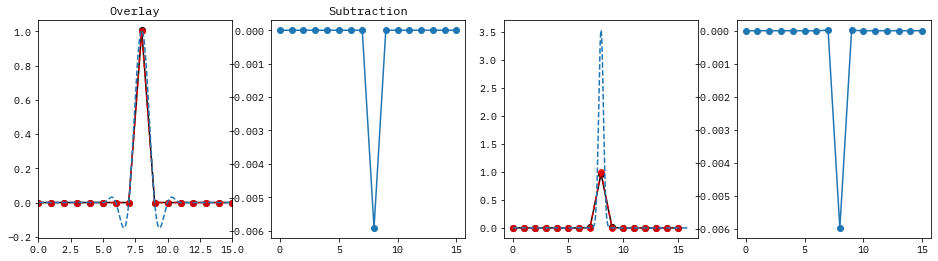

3.530169602442425


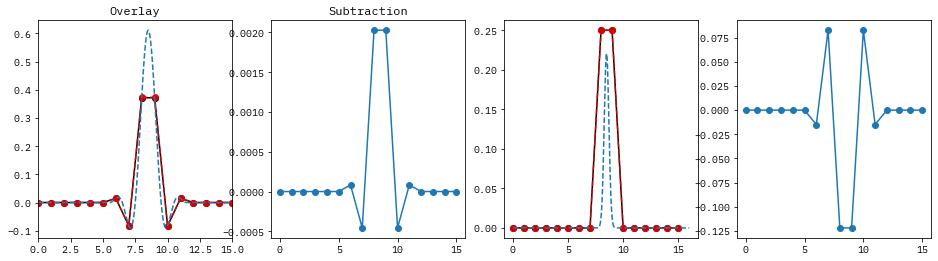

3.530169602442425


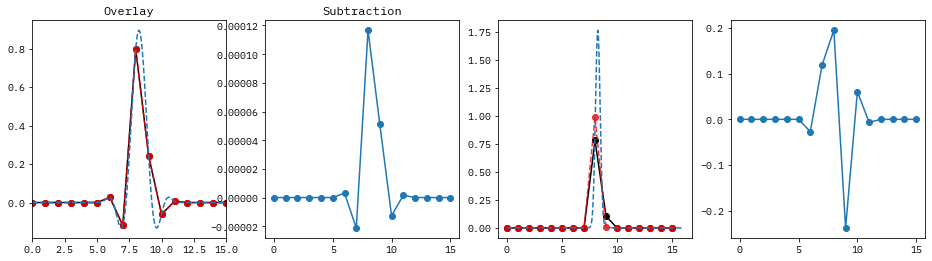

3.530169602442425


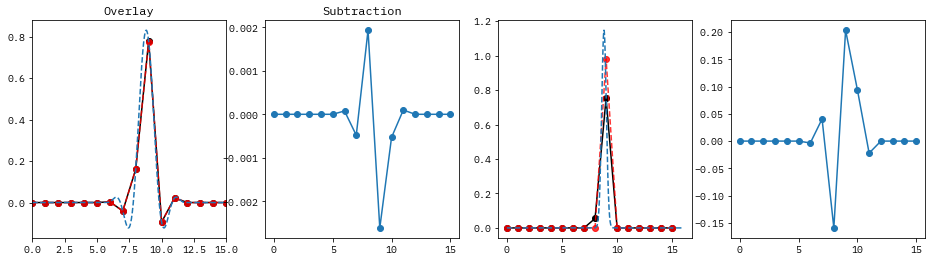

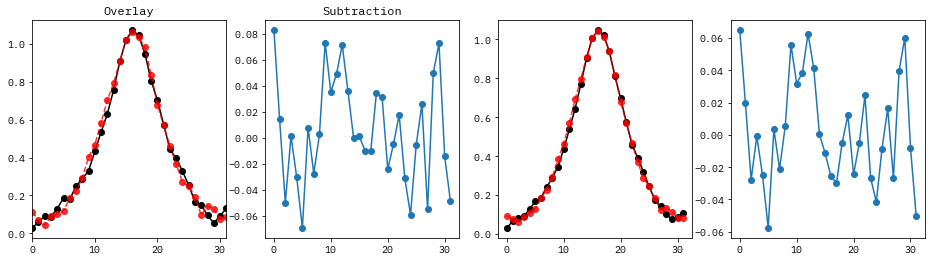

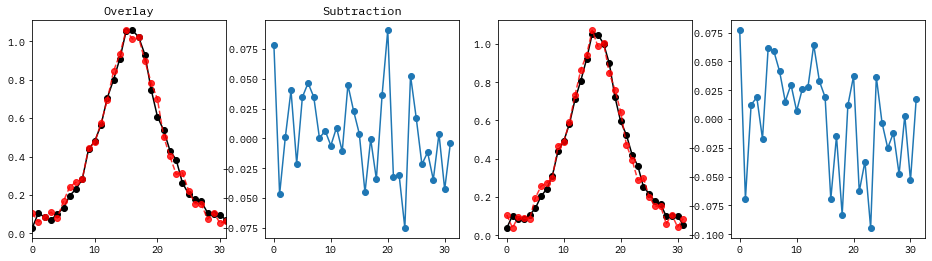

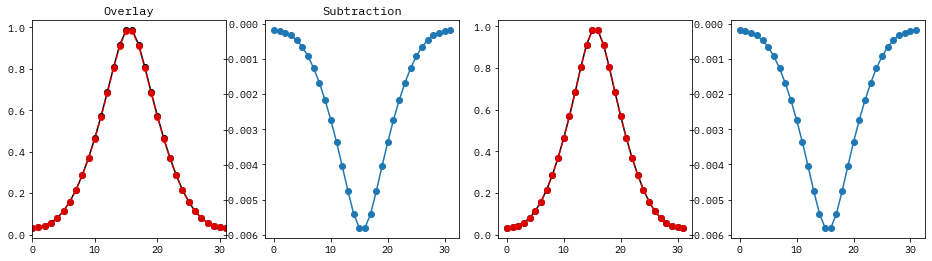

In [8]:
distortions = ((0,0),
        (1/2,1/2),
        (1/4,1/4),
        (1/1.2312,1/3.1413))

for i,d in enumerate(distortions):
    data = read_check_image_set(num=i)
    fig, axs = plot_cross_section(data, d)
    plt.show()

for i in range(4,7):
    data = read_check_image_set(num=i)
    fig, axs = plot_cross_section(data, distortion=None)
    plt.show()

# Major Differences

This plot shows a perfect Lanczos 3 distribution (blue) overlayed with the rained (black) and the drizzled (red) plots. The Lanczos 3 distribution passes through the rain data point exactly, while it is a near miss through the drizzled image.

3.530169602442425


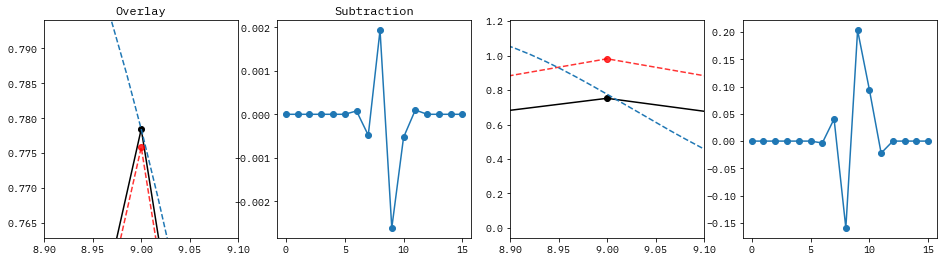

In [9]:
plot_index = 3
data = read_check_image_set(num=plot_index)
fig,axs = plot_cross_section(data, distortion=distortions[plot_index])

zoom_index = 9
dx = 0.1

vals = data['rain_lanc3'][int(data['rain_lanc3'].shape[0]/2)]
dy = vals[zoom_index]*0.02
axs[0].set_xlim(zoom_index-dx, zoom_index+dx)
axs[0].set_ylim(vals[zoom_index]-dy, vals[zoom_index]+dy)


zoom_index = 9
dx = 0.1

vals = data['rain_gauss'][int(data['rain_gauss'].shape[0]/2)]
dy = vals[zoom_index]*0.02
axs[2].set_xlim(zoom_index-dx, zoom_index+dx)
#axs[2].set_ylim(vals[zoom_index]-dy, vals[zoom_index]+dy)

plt.show()

# Real Data

Same plot as the previous section, but with real data. For some reason, drizzle would not work properly with the real data + Gaussian kernel. Again we see systematic differences between Rain and drizzle in the lower right plot, the shape of which is similar to the original image, indicating that it is again just a renormalization issue. However, we see a median division of 99.875%, indicating that Rain is extremely similar to drizzle.

Large shifts near the edges of the distortion map are due to the fact that the distortion map is poorly constrained at the edges, so the pixels are likely to fall off. Drizzle appears to "fold" back these pixels and put some of their value back on the edge. There is typically a buildup of flux in a drizzled image near the edges of the image due to this effect in drizzled image. Rain simply does not count these pixel values.

In [10]:
data_folder = '../check_images/'

num = 60
orig_filename = os.path.join(data_folder, 'r_n{:04d}.fits'.format(num))
rain_gauss_filename = os.path.join(data_folder, 'rain_gauss_r_n{:04d}.fits'.format(num))
rain_lanc3_filename = os.path.join(data_folder, 'rain_lanc3_r_n{:04d}.fits'.format(num))
driz_gauss_filename = os.path.join(data_folder, 'drz_gauss_r_n{:04d}.fits'.format(num))
driz_lanc3_filename = os.path.join(data_folder, 'drz_lanc3_r_n{:04d}.fits'.format(num))
dist_x_folder = '../distortion/nirc2_distort_X_post20150413_v1.fits'
dist_y_folder = '../distortion/nirc2_distort_Y_post20150413_v1.fits'

data = read_check_image_set(filenames=[orig_filename, rain_gauss_filename, rain_lanc3_filename, driz_gauss_filename, driz_lanc3_filename, dist_x_folder, dist_y_folder])

with np.errstate(divide='ignore', invalid='ignore'):
    div_arr = data['driz_lanc3']/data['rain_lanc3']

median = np.median(div_arr) # filter out noise
print('Lanc3 Median -> {:>.3f}%'.format(median*100))

vms = ((-1e5, 1e5), (-1e3,1e3))
fig,axs = plot_set(data, vms=vms)

FileNotFoundError: [Errno 2] No such file or directory: '../distortion/nirc2_distort_X_post20150413_v1.fits'

# Conclusion

Rain seems to differ from drizzle, but only slightly. The distortion maps are applied are nearly the same, but differ only in magnitude of the pixel flux by ~0.5%.

Key differences:

* Renormalization: Based on the drizzle source code, drizzle does a renormalization based on the existing pixel values within the pixel. The pixel value being determined by a weighted average. Rain however, uses an analytical solution to the area of the kernels to normalize flux. This difference in renormalization schemes allows for conservation of flux in both cases, but different resulting shapes since negative values ("negative flux") is allowed. Negative flux in this case is valid since we subtracted the noise floor in previous reduction steps. Additionally, the fact that the perfect Lanczos 3 distribution passes through the Rain data point lends to the validity of the Rain solution.
* Edges: Drizzle seems to pile up flux near the edges of the image and some of the pixel flux that falls outside the image is "folded" back onto the image. Rain simply does not count these cases and the pixel flux that falls outside of the boundary are summed into the "missing pixels"

Rain is effectively good enough for most cases as compared to drizzle. Some extra analysis of the treatment of noise may be needed, but photometrically, Rain is comparable in performance to drizzle.